**1. Import Libraries and Setup**

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, roc_auc_score, confusion_matrix,
                           classification_report, roc_curve, precision_recall_curve)
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('ggplot')
sns.set_palette("husl")

print("="*60)
print("BREAST CANCER PREDICTION USING MACHINE LEARNING")
print("="*60)

BREAST CANCER PREDICTION USING MACHINE LEARNING


**2. Load and Explore Dataset**

In [3]:
# TASK 1: DATA EXPLORATION
print("\n" + "="*50)
print("TASK 1: DATA EXPLORATION")
print("="*50)

# Load the dataset using your specified path
dataset_path = '/content/drive/MyDrive/Colab Notebooks/Assignment_AI/breast_cancer_dataset.csv'

try:
    df = pd.read_csv(dataset_path)
    print("✓ Dataset loaded successfully from:", dataset_path)
except FileNotFoundError:
    print("⚠ Dataset not found at:", dataset_path)
    print("Please check the path and ensure the file exists.")


print(f"\nInitial Dataset Shape: {df.shape}")

# Basic dataset information
print("\n--- Dataset Overview ---")
print("First 5 rows:")
print(df.head())
print(f"\nData Types:")
print(df.dtypes)


TASK 1: DATA EXPLORATION
✓ Dataset loaded successfully from: /content/drive/MyDrive/Colab Notebooks/Assignment_AI/breast_cancer_dataset.csv

Initial Dataset Shape: (569, 32)

--- Dataset Overview ---
First 5 rows:
         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3 

**3. Check Data Quality and Target Distribution**

In [4]:
# Check for missing values before feature selection
print(f"\nMissing Values (raw dataset):")
print(df.isnull().sum())
if df.isnull().sum().sum() > 0:
    print("⚠ Missing values detected in the raw dataset. These will be handled after feature selection.")

# Separate features and target
# Drop 'id' column as it's not a predictive feature
if 'id' in df.columns:
    X_raw = df.drop(['id', 'diagnosis'], axis=1)
    print("\n✓ 'id' column dropped from features.")
else:
    X_raw = df.drop(['diagnosis'], axis=1)
    print("⚠ 'id' column not found. Proceeding without dropping it specifically from features.")

y = df['diagnosis']

print(f"\nNumber of Features for modeling: {X_raw.shape[1]}")
print(f"Number of Samples: {X_raw.shape[0]}")

# Target variable distribution
print("\n--- Target Variable Analysis ---")
target_dist = y.value_counts()
benign_count = target_dist.get('B', 0)
malignant_count = target_dist.get('M', 0)
total_samples = len(y)

print("Diagnosis Distribution:")
print(target_dist)
print(f"Benign (B): {benign_count} ({benign_count/total_samples*100:.1f}%)")
print(f"Malignant (M): {malignant_count} ({malignant_count/total_samples*100:.1f}%)")


Missing Values (raw dataset):
id                         0
diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

✓ 'id' column dropped from 

**4. Exploratory Data Analysis Visualizations**

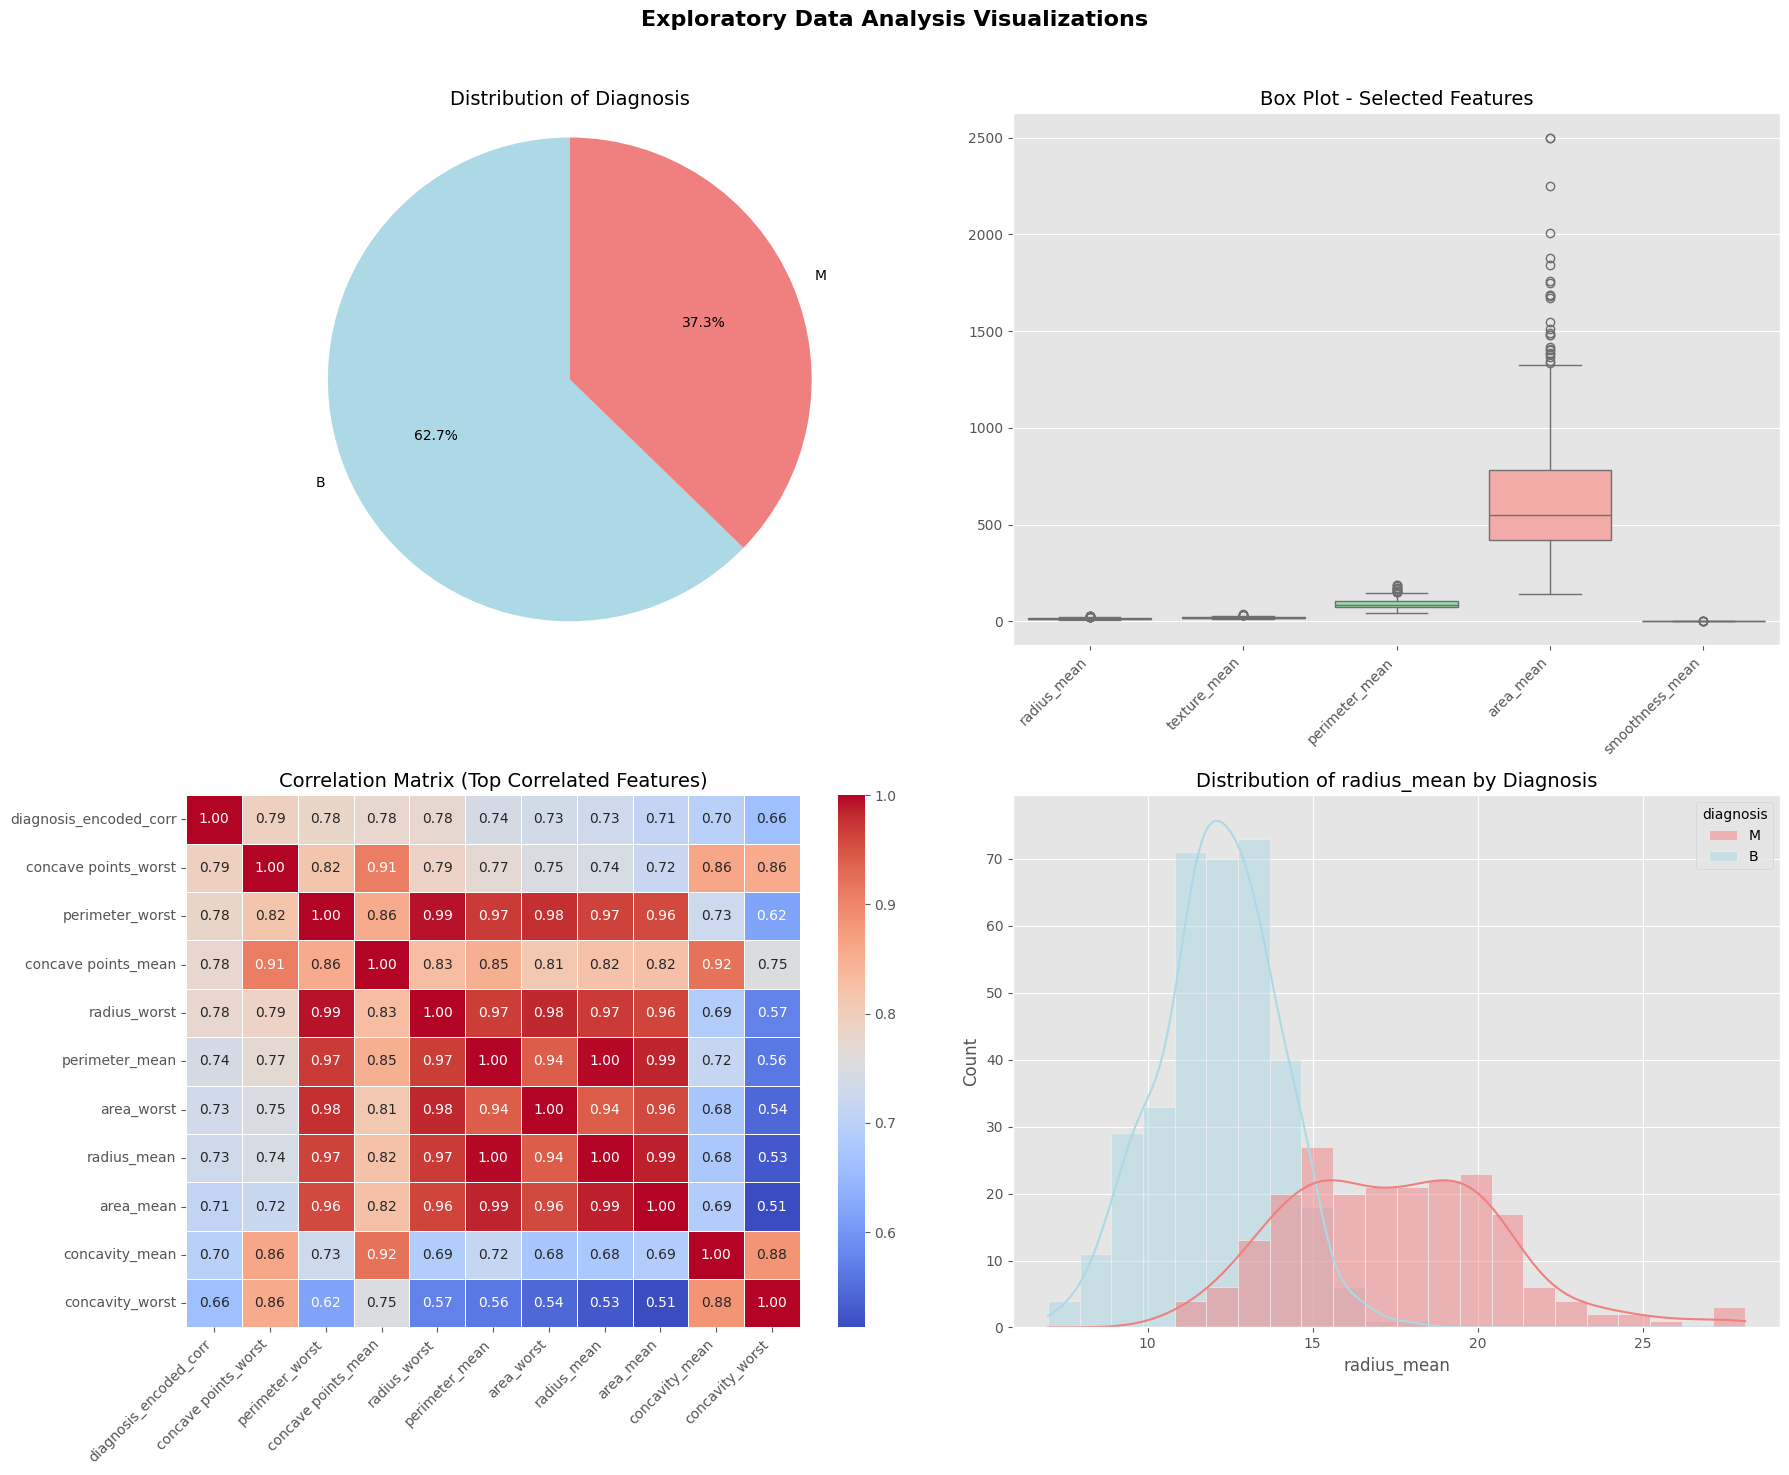

In [8]:
# Create visualizations for EDA
fig, axes = plt.subplots(2, 2, figsize=(18, 15))
fig.suptitle("Exploratory Data Analysis Visualizations", fontsize=16, fontweight='bold')

# Target distribution pie chart
axes[0,0].pie(target_dist.values, labels=target_dist.index, autopct='%1.1f%%',
              colors=['lightblue', 'lightcoral'], startangle=90)
axes[0,0].set_title('Distribution of Diagnosis', fontsize=14)
axes[0,0].axis('equal')

# Box plot for first few features
numeric_cols_for_plot = X_raw.select_dtypes(include=[np.number]).columns
if len(numeric_cols_for_plot) > 5:
    numeric_cols_to_plot = numeric_cols_for_plot[:5]
else:
    numeric_cols_to_plot = numeric_cols_for_plot

if not numeric_cols_to_plot.empty:
    sns.boxplot(data=X_raw[numeric_cols_to_plot], ax=axes[0,1], palette="pastel")
    axes[0,1].set_title('Box Plot - Selected Features', fontsize=14)
    axes[0,1].tick_params(axis='x', rotation=45)
    for label in axes[0,1].get_xticklabels():
        label.set_ha('right')

else:
    axes[0,1].text(0.5, 0.5, "No numeric features to plot.", ha='center', va='center')
    axes[0,1].set_title('Box Plot - Selected Features', fontsize=14)

# Correlation heatmap
df_for_corr = df.copy()
le_corr = LabelEncoder()
df_for_corr['diagnosis_encoded_corr'] = le_corr.fit_transform(df_for_corr['diagnosis'])
numeric_df_for_corr = df_for_corr.select_dtypes(include=[np.number])
if 'id' in numeric_df_for_corr.columns:
    numeric_df_for_corr = numeric_df_for_corr.drop(columns=['id'])

correlation_matrix = numeric_df_for_corr.corr()

# Select top correlated features with the target for the heatmap
cols_for_heatmap = correlation_matrix.nlargest(11, 'diagnosis_encoded_corr')['diagnosis_encoded_corr'].index
if 'diagnosis_encoded_corr' not in cols_for_heatmap:
    cols_for_heatmap = list(cols_for_heatmap[:10]) + ['diagnosis_encoded_corr']

if len(cols_for_heatmap) > 1:
    sns.heatmap(numeric_df_for_corr[cols_for_heatmap].corr(), annot=True, cmap='coolwarm', fmt=".2f",
                linewidths=.5, ax=axes[1,0])
    axes[1,0].set_title('Correlation Matrix (Top Correlated Features)', fontsize=14)
    axes[1,0].tick_params(axis='x', rotation=45)
    for label in axes[1,0].get_xticklabels():
        label.set_ha('right')

    axes[1,0].tick_params(axis='y', rotation=0)
else:
    axes[1,0].text(0.5, 0.5, "Not enough numeric data for heatmap.", ha='center', va='center')
    axes[1,0].set_title('Correlation Matrix', fontsize=14)

# Distribution of a key feature by diagnosis
key_features_to_try = ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean']
key_feature_found = None
for kf in key_features_to_try:
    if kf in X_raw.columns:
        key_feature_found = kf
        break
if not key_feature_found and not X_raw.select_dtypes(include=[np.number]).empty:
    key_feature_found = X_raw.select_dtypes(include=[np.number]).columns[0]

if key_feature_found:
    sns.histplot(data=df, x=key_feature_found, hue='diagnosis', kde=True, ax=axes[1,1],
                palette={'M':'lightcoral', 'B':'lightblue'})
    axes[1,1].set_title(f'Distribution of {key_feature_found} by Diagnosis', fontsize=14)
else:
    axes[1,1].text(0.5, 0.5, "No key feature to plot.", ha='center', va='center')
    axes[1,1].set_title('Key Feature Distribution by Diagnosis', fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

**5. Statistical Summary and Feature Correlation Analysis**

In [9]:
# Statistical summary
print("\n--- Statistical Summary of Features ---")
numeric_features_eda = X_raw.select_dtypes(include=[np.number])
print("Basic Statistics for Numerical Features (used for modeling):")
print(numeric_features_eda.describe().T)

# Correlation with target
print("\n--- Feature-Target Correlations ---")
df_encoded_target_corr = df.copy()
label_encoder_corr = LabelEncoder()
df_encoded_target_corr['diagnosis_encoded'] = label_encoder_corr.fit_transform(df_encoded_target_corr['diagnosis'])

# Ensure only numeric features from X_raw are used for correlation with target
numeric_X_raw = X_raw.select_dtypes(include=[np.number])
df_for_target_corr = pd.concat([numeric_X_raw, df_encoded_target_corr['diagnosis_encoded']], axis=1)

correlations_with_target = df_for_target_corr.corr()['diagnosis_encoded'].sort_values(key=abs, ascending=False)
if 'diagnosis_encoded' in correlations_with_target.index:
    correlations_with_target = correlations_with_target.drop('diagnosis_encoded')

print("Top 10 features correlated with diagnosis:")
print(correlations_with_target.head(10))


--- Statistical Summary of Features ---
Basic Statistics for Numerical Features (used for modeling):
                         count        mean         std         min  \
radius_mean              569.0   14.127292    3.524049    6.981000   
texture_mean             569.0   19.289649    4.301036    9.710000   
perimeter_mean           569.0   91.969033   24.298981   43.790000   
area_mean                569.0  654.889104  351.914129  143.500000   
smoothness_mean          569.0    0.096360    0.014064    0.052630   
compactness_mean         569.0    0.104341    0.052813    0.019380   
concavity_mean           569.0    0.088799    0.079720    0.000000   
concave points_mean      569.0    0.048919    0.038803    0.000000   
symmetry_mean            569.0    0.181162    0.027414    0.106000   
fractal_dimension_mean   569.0    0.062798    0.007060    0.049960   
radius_se                569.0    0.405172    0.277313    0.111500   
texture_se               569.0    1.216853    0.551648    

**6. Data Preparation and Preprocessing**

In [10]:
# TASK 2: DATA PREPARATION
print("\n" + "="*50)
print("TASK 2: DATA PREPARATION")
print("="*50)

X = X_raw  # Use the version of X where 'id' is already dropped
print(f"Features shape for modeling: {X.shape}")
print(f"Target shape: {y.shape}")

# Handle missing values (if any)
missing_count = X.isnull().sum().sum()
print(f"\nTotal missing values in selected features (X): {missing_count}")

if missing_count > 0:
    print("Imputing missing values with median for selected features...")
    from sklearn.impute import SimpleImputer

    numeric_cols = X.select_dtypes(include=np.number).columns
    non_numeric_cols = X.select_dtypes(exclude=np.number).columns

    X_numeric = X[numeric_cols]
    X_non_numeric = X[non_numeric_cols]

    imputer = SimpleImputer(strategy='median')
    X_numeric_imputed = pd.DataFrame(imputer.fit_transform(X_numeric), columns=numeric_cols, index=X.index)

    X = pd.concat([X_numeric_imputed, X_non_numeric], axis=1)
    X = X[X_raw.columns]  # Reorder to original column order
    print("✓ Missing values imputed in X.")
else:
    print("✓ No missing values found in selected features (X).")

# Encode target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print(f"\nTarget encoding map: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")


TASK 2: DATA PREPARATION
Features shape for modeling: (569, 30)
Target shape: (569,)

Total missing values in selected features (X): 0
✓ No missing values found in selected features (X).

Target encoding map: {'B': np.int64(0), 'M': np.int64(1)}


**7. Feature Scaling**

In [11]:
# Feature scaling
X_numeric_for_scaling = X.select_dtypes(include=[np.number])
if X_numeric_for_scaling.shape[1] != X.shape[1]:
    print("⚠ Non-numeric columns detected in X. StandardScaler will only be applied to numeric columns.")

print("\n--- Feature Scaling ---")
scaler = StandardScaler()
X_scaled_array = scaler.fit_transform(X_numeric_for_scaling)
X_scaled = pd.DataFrame(X_scaled_array, columns=X_numeric_for_scaling.columns, index=X.index)

print("✓ Features scaled using StandardScaler.")
if not X_scaled.empty:
    first_feature_name = X_scaled.columns[0]
    print("Scaling comparison (first feature example):")
    print(f"Original '{first_feature_name}' - Mean: {X[first_feature_name].mean():.3f}, Std: {X[first_feature_name].std():.3f}")
    print(f"Scaled '{first_feature_name}' - Mean: {X_scaled[first_feature_name].mean():.3f}, Std: {X_scaled[first_feature_name].std():.3f}")


--- Feature Scaling ---
✓ Features scaled using StandardScaler.
Scaling comparison (first feature example):
Original 'radius_mean' - Mean: 14.127, Std: 3.524
Scaled 'radius_mean' - Mean: -0.000, Std: 1.001


**8. Train-Test Split and Model Initialization**

In [12]:
# TASK 3: MODEL TRAINING
print("\n" + "="*50)
print("TASK 3: MODEL TRAINING")
print("="*50)

# Train-test split
TEST_SIZE = 0.2
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_encoded)

print(f"Train-test split ratio: {100*(1-TEST_SIZE):.0f}%-{100*TEST_SIZE:.0f}%")
print(f"Training set size: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Test set size: {X_test.shape[0]} samples, {X_test.shape[1]} features")

train_class_counts = np.bincount(y_train)
test_class_counts = np.bincount(y_test)
print(f"Stratification check: Train class distribution = {train_class_counts} (B: {train_class_counts[0]}, M: {train_class_counts[1]})")
print(f"Stratification check: Test class distribution = {test_class_counts} (B: {test_class_counts[0]}, M: {test_class_counts[1]})")

# Initialize models with default parameters
models = {
    'Logistic Regression': LogisticRegression(random_state=RANDOM_STATE, max_iter=1000),
    'Support Vector Machine': SVC(random_state=RANDOM_STATE, probability=True),
    'Decision Tree': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'Random Forest': RandomForestClassifier(random_state=RANDOM_STATE),
    'K-Nearest Neighbors': KNeighborsClassifier()
}


TASK 3: MODEL TRAINING
Train-test split ratio: 80%-20%
Training set size: 455 samples, 30 features
Test set size: 114 samples, 30 features
Stratification check: Train class distribution = [285 170] (B: 285, M: 170)
Stratification check: Test class distribution = [72 42] (B: 72, M: 42)


**9. Train All Models**

In [13]:
print("\n--- Model Training (with default parameters) ---")
trained_models = {}
model_default_params = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    trained_models[name] = model
    model_default_params[name] = model.get_params()
    print(f"✓ {name} trained successfully.")


--- Model Training (with default parameters) ---
Training Logistic Regression...
✓ Logistic Regression trained successfully.
Training Support Vector Machine...
✓ Support Vector Machine trained successfully.
Training Decision Tree...
✓ Decision Tree trained successfully.
Training Random Forest...
✓ Random Forest trained successfully.
Training K-Nearest Neighbors...
✓ K-Nearest Neighbors trained successfully.


**10. Model Evaluation**

In [14]:
# TASK 4: MODEL EVALUATION AND VISUALIZATION
print("\n" + "="*50)
print("TASK 4: MODEL EVALUATION AND VISUALIZATION")
print("="*50)

# Evaluate all models
results_initial = {}
predictions_initial = {}

print("\n--- Initial Model Evaluation (on Test Set) ---")
for name, model in trained_models.items():
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    predictions_initial[name] = {
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else float('nan')

    results_initial[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc
    }

    print(f"\nMetrics for {name}:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"  AUC:       {auc:.4f}" if not np.isnan(auc) else "  AUC:       N/A")

# Create results DataFrame
results_initial_df = pd.DataFrame(results_initial).T.sort_values(by='F1-Score', ascending=False)
print("\n--- Performance Comparison (Initial Models) ---")
print(results_initial_df)

# Identify best performing model
best_initial_model_name = results_initial_df['F1-Score'].idxmax()
best_initial_model_metrics = results_initial_df.loc[best_initial_model_name]
print(f"\n🏆 Best performing initial model (based on F1-Score): {best_initial_model_name}")
print(f"   F1-Score: {best_initial_model_metrics['F1-Score']:.4f}")
print(f"   Accuracy: {best_initial_model_metrics['Accuracy']:.4f}")
print(f"   AUC:      {best_initial_model_metrics['AUC']:.4f}")


TASK 4: MODEL EVALUATION AND VISUALIZATION

--- Initial Model Evaluation (on Test Set) ---

Metrics for Logistic Regression:
  Accuracy:  0.9649
  Precision: 0.9750
  Recall:    0.9286
  F1-Score:  0.9512
  AUC:       0.9960

Metrics for Support Vector Machine:
  Accuracy:  0.9737
  Precision: 1.0000
  Recall:    0.9286
  F1-Score:  0.9630
  AUC:       0.9954

Metrics for Decision Tree:
  Accuracy:  0.9298
  Precision: 0.9048
  Recall:    0.9048
  F1-Score:  0.9048
  AUC:       0.9246

Metrics for Random Forest:
  Accuracy:  0.9737
  Precision: 1.0000
  Recall:    0.9286
  F1-Score:  0.9630
  AUC:       0.9929

Metrics for K-Nearest Neighbors:
  Accuracy:  0.9561
  Precision: 0.9744
  Recall:    0.9048
  F1-Score:  0.9383
  AUC:       0.9816

--- Performance Comparison (Initial Models) ---
                        Accuracy  Precision    Recall  F1-Score       AUC
Support Vector Machine  0.973684   1.000000  0.928571  0.962963  0.995370
Random Forest           0.973684   1.000000  0.928

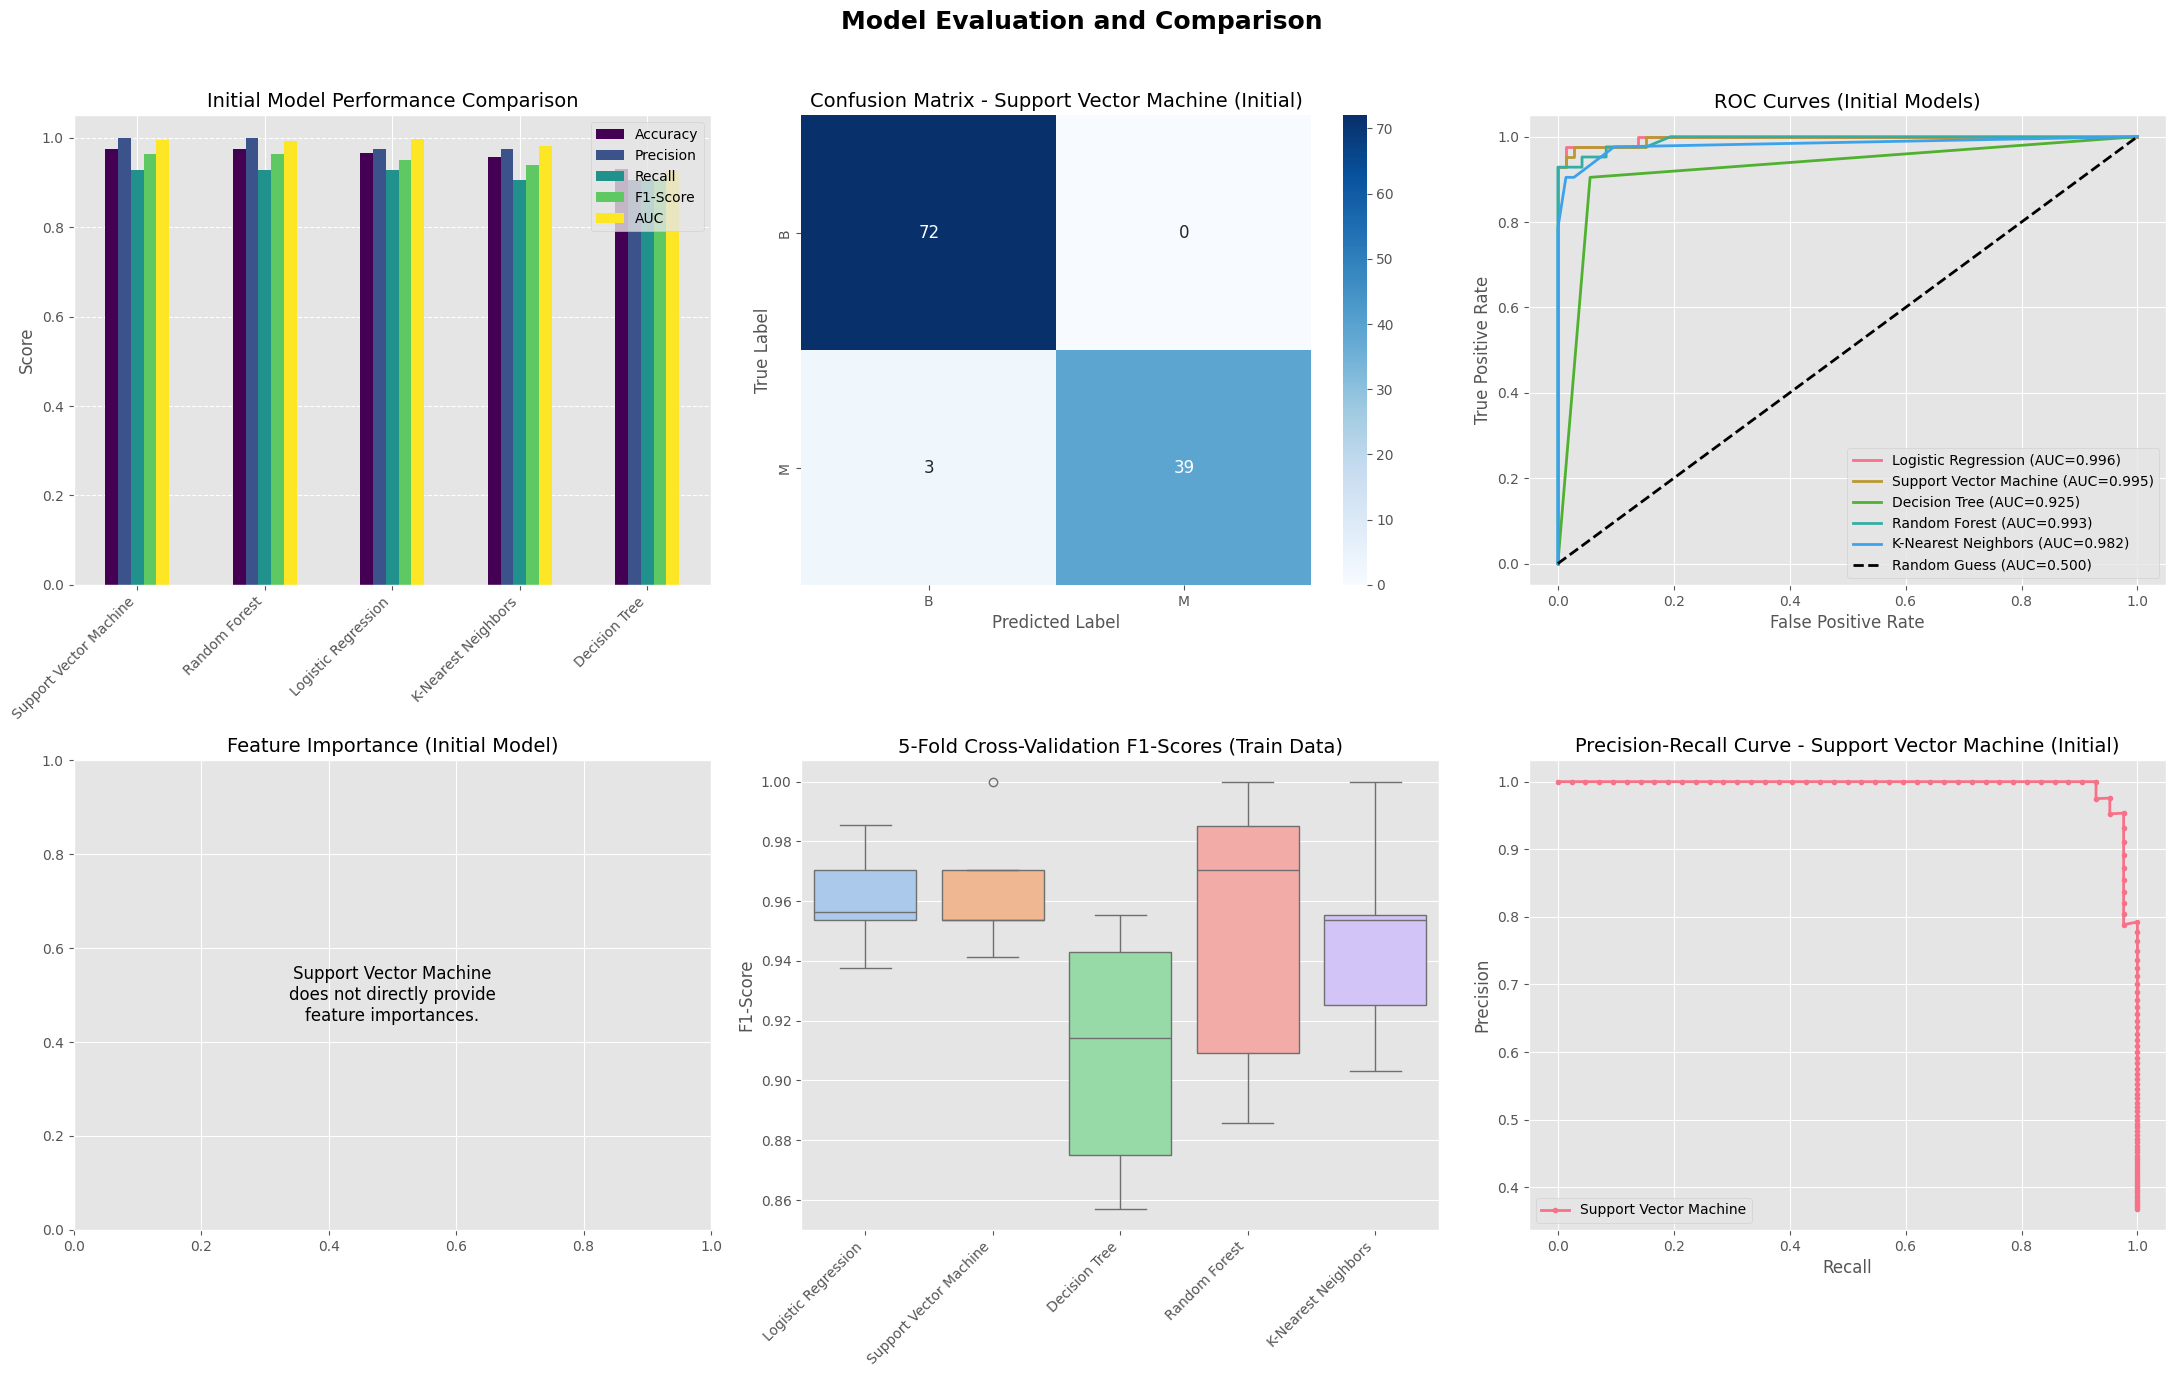

In [18]:
# Visualizations for Model Evaluation
fig_eval, axes_eval = plt.subplots(2, 3, figsize=(22, 14))
fig_eval.suptitle("Model Evaluation and Comparison", fontsize=18, fontweight='bold')

# 1. Performance comparison bar chart
results_initial_df.plot(kind='bar', ax=axes_eval[0,0], colormap='viridis')
axes_eval[0,0].set_title('Initial Model Performance Comparison', fontsize=14)
axes_eval[0,0].set_ylabel('Score', fontsize=12)
axes_eval[0,0].tick_params(axis='x', rotation=45)
for label in axes_eval[0,0].get_xticklabels():
    label.set_ha('right')

axes_eval[0,0].grid(axis='y', linestyle='--')
axes_eval[0,0].legend(fontsize=10)

# 2. Confusion Matrix for the best initial model
cm_initial = confusion_matrix(y_test, predictions_initial[best_initial_model_name]['y_pred'])
sns.heatmap(cm_initial, annot=True, fmt='d', cmap='Blues', ax=axes_eval[0,1],
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, annot_kws={"size":12})
axes_eval[0,1].set_title(f'Confusion Matrix - {best_initial_model_name} (Initial)', fontsize=14)
axes_eval[0,1].set_ylabel('True Label', fontsize=12)
axes_eval[0,1].set_xlabel('Predicted Label', fontsize=12)

# 3. ROC Curves for all models
for name, pred_data in predictions_initial.items():
    if pred_data['y_pred_proba'] is not None:
        fpr, tpr, _ = roc_curve(y_test, pred_data['y_pred_proba'])
        auc_score_val = results_initial[name]['AUC']
        axes_eval[0,2].plot(fpr, tpr, label=f'{name} (AUC={auc_score_val:.3f})', linewidth=2)
axes_eval[0,2].plot([0, 1], [0, 1], 'k--', label='Random Guess (AUC=0.500)', linewidth=2)
axes_eval[0,2].set_xlabel('False Positive Rate', fontsize=12)
axes_eval[0,2].set_ylabel('True Positive Rate', fontsize=12)
axes_eval[0,2].set_title('ROC Curves (Initial Models)', fontsize=14)
axes_eval[0,2].legend(fontsize=10)
axes_eval[0,2].grid(True)

# 4. Feature importance (for tree-based models)
best_initial_model_object = trained_models[best_initial_model_name]
if hasattr(best_initial_model_object, 'feature_importances_'):
    importances = best_initial_model_object.feature_importances_
    feature_names = X_scaled.columns
    indices = np.argsort(importances)[::-1][:10]

    sns.barplot(x=[feature_names[i] for i in indices], y=importances[indices], ax=axes_eval[1,0], palette='mako')
    axes_eval[1,0].set_title(f'Top 10 Feature Importances - {best_initial_model_name} (Initial)', fontsize=14)
    axes_eval[1,0].set_xticklabels([feature_names[i] for i in indices], rotation=45, ha="right")
    axes_eval[1,0].set_ylabel('Importance', fontsize=12)
else:
    axes_eval[1,0].text(0.5, 0.5, f'{best_initial_model_name}\ndoes not directly provide\nfeature importances.',
                   ha='center', va='center', transform=axes_eval[1,0].transAxes, fontsize=12)
    axes_eval[1,0].set_title('Feature Importance (Initial Model)', fontsize=14)

# 5. Cross-validation F1-scores
cv_scores_f1 = {}
for name, model_obj in models.items():
    cv_score = cross_val_score(model_obj, X_train, y_train, cv=5, scoring='f1', n_jobs=-1)
    cv_scores_f1[name] = cv_score
cv_df = pd.DataFrame(cv_scores_f1)
sns.boxplot(data=cv_df, ax=axes_eval[1,1], palette='pastel')
axes_eval[1,1].set_title('5-Fold Cross-Validation F1-Scores (Train Data)', fontsize=14)
axes_eval[1,1].set_ylabel('F1-Score', fontsize=12)
axes_eval[1,1].tick_params(axis='x', rotation=45)
for label in axes_eval[1,1].get_xticklabels():
    label.set_ha('right')


# 6. Precision-Recall Curve
if predictions_initial[best_initial_model_name]['y_pred_proba'] is not None:
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, predictions_initial[best_initial_model_name]['y_pred_proba'])
    axes_eval[1,2].plot(recall_vals, precision_vals, marker='.', label=best_initial_model_name, linewidth=2)
    axes_eval[1,2].set_xlabel('Recall', fontsize=12)
    axes_eval[1,2].set_ylabel('Precision', fontsize=12)
    axes_eval[1,2].set_title(f'Precision-Recall Curve - {best_initial_model_name} (Initial)', fontsize=14)
    axes_eval[1,2].grid(True)
    axes_eval[1,2].legend(fontsize=10)
else:
    axes_eval[1,2].text(0.5, 0.5, 'Precision-Recall Curve\nnot available for this model type.',
                   ha='center', va='center', transform=axes_eval[1,2].transAxes, fontsize=12)
    axes_eval[1,2].set_title(f'Precision-Recall Curve (Initial Model)', fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

**12. Hyperparameter Tuning**

In [19]:
# Hyperparameter tuning for the best initial model
print(f"\n--- Hyperparameter Tuning for {best_initial_model_name} ---")

# Define parameter grids
param_grids = {
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear', 'lbfgs'],
        'penalty': ['l1', 'l2']
    },
    'Support Vector Machine': {
        'C': [0.1, 1, 10],
        'kernel': ['rbf', 'linear', 'poly'],
        'gamma': ['scale', 'auto', 0.1, 1]
    },
    'Decision Tree': {
        'max_depth': [None, 5, 10, 15, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4, 5],
        'criterion': ['gini', 'entropy']
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'K-Nearest Neighbors': {
        'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    }
}

# Special handling for Logistic Regression penalties
if best_initial_model_name == 'Logistic Regression':
    current_param_grid = [
        {'solver': ['liblinear'], 'penalty': ['l1', 'l2'], 'C': param_grids['Logistic Regression']['C']},
        {'solver': ['lbfgs'], 'penalty': ['l2'], 'C': param_grids['Logistic Regression']['C']}
    ]
else:
    current_param_grid = param_grids.get(best_initial_model_name, None)

best_tuned_model = None
tuned_model_results = {}

if current_param_grid:
    print(f"Tuning hyperparameters for {best_initial_model_name} using GridSearchCV...")
    grid_search = GridSearchCV(
        estimator=models[best_initial_model_name],
        param_grid=current_param_grid,
        cv=5,
        scoring='f1',
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train)
    best_tuned_model = grid_search.best_estimator_

    print(f"\nBest parameters found for {best_initial_model_name}: {grid_search.best_params_}")
    print(f"Best cross-validation F1-score from GridSearchCV: {grid_search.best_score_:.4f}")
else:
    print(f"No parameter grid defined for {best_initial_model_name}. Skipping tuning.")
    best_tuned_model = best_initial_model_object
    tuned_model_results = results_initial[best_initial_model_name]


--- Hyperparameter Tuning for Support Vector Machine ---
Tuning hyperparameters for Support Vector Machine using GridSearchCV...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best parameters found for Support Vector Machine: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation F1-score from GridSearchCV: 0.9647


**13. Evaluate Tuned Model and Compare Performance**

In [22]:
if best_tuned_model and current_param_grid:
    # Evaluate the best tuned model on the test set
    y_pred_tuned = best_tuned_model.predict(X_test)
    y_pred_proba_tuned = best_tuned_model.predict_proba(X_test)[:, 1] if hasattr(best_tuned_model, 'predict_proba') else None

    tuned_accuracy = accuracy_score(y_test, y_pred_tuned)
    tuned_precision = precision_score(y_test, y_pred_tuned, zero_division=0)
    tuned_recall = recall_score(y_test, y_pred_tuned, zero_division=0)
    tuned_f1 = f1_score(y_test, y_pred_tuned, zero_division=0)
    tuned_auc = roc_auc_score(y_test, y_pred_proba_tuned) if y_pred_proba_tuned is not None else float('nan')

    tuned_model_results = {
        'Accuracy': tuned_accuracy,
        'Precision': tuned_precision,
        'Recall': tuned_recall,
        'F1-Score': tuned_f1,
        'AUC': tuned_auc
    }

    print(f"\n--- Performance of Tuned {best_initial_model_name} on Test Set ---")
    print(f"  Accuracy:  {tuned_accuracy:.4f}")
    print(f"  Precision: {tuned_precision:.4f}")
    print(f"  Recall:    {tuned_recall:.4f}")
    print(f"  F1-Score:  {tuned_f1:.4f}")
    print(f"  AUC:       {tuned_auc:.4f}" if not np.isnan(tuned_auc) else "  AUC:       N/A")

    # Comparison Table: Before vs After Tuning
    print(f"\n--- Performance Comparison: {best_initial_model_name} (Before vs After Tuning) ---")
    print(f"{'Metric':<12} {'Before':<10} {'After':<10} {'Improvement':<12}")
    print("-" * 50)

    for metric_name in ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']:
        before_score = results_initial[best_initial_model_name][metric_name]
        after_score = tuned_model_results[metric_name]
        improvement = after_score - before_score if not (np.isnan(before_score) or np.isnan(after_score)) else float('nan')

        before_str = f"{before_score:<10.4f}" if not np.isnan(before_score) else "N/A       "
        after_str = f"{after_score:<10.4f}" if not np.isnan(after_score) else "N/A       "
        improv_str = f"{improvement:+.4f}" if not np.isnan(improvement) else "N/A"

        print(f"{metric_name:<12} {before_str} {after_str} {improv_str}")

else:
    print(f"No parameter grid defined for {best_initial_model_name}. Skipping tuning.")
    best_tuned_model = best_initial_model_object
    tuned_model_results = results_initial[best_initial_model_name]


--- Performance of Tuned Support Vector Machine on Test Set ---
  Accuracy:  0.9737
  Precision: 1.0000
  Recall:    0.9286
  F1-Score:  0.9630
  AUC:       0.9927

--- Performance Comparison: Support Vector Machine (Before vs After Tuning) ---
Metric       Before     After      Improvement 
--------------------------------------------------
Accuracy     0.9737     0.9737     +0.0000
Precision    1.0000     1.0000     +0.0000
Recall       0.9286     0.9286     +0.0000
F1-Score     0.9630     0.9630     +0.0000
AUC          0.9954     0.9927     -0.0026


In [24]:
# TASK 5: CONCLUSION AND FUTURE WORK

print("\n" + "="*50)
print("TASK 5: DATA FOR CONCLUSION AND FUTURE WORK")
print("="*50)

print("\n--- DATA FOR REPORT SUMMARY ---")
print(f"Dataset used: Wisconsin Diagnostic Breast Cancer (WDBC)")
print(f"Total samples analyzed: {total_samples}")
print(f"Number of features used for modeling: {X_scaled.shape[1]}") # Should be 30
print(f"Target class distribution: Benign (B): {benign_count} ({benign_count/total_samples*100:.1f}%), Malignant (M): {malignant_count} ({malignant_count/total_samples*100:.1f}%)")

print(f"\nBest Performing Model (after tuning, if applicable): {final_best_model_name_for_report}")
print(f"  Final F1-Score: {final_best_f1_for_report:.4f}")
print(f"  Final Accuracy: {final_best_accuracy_for_report:.4f}")
print(f"  Final AUC:      {final_best_auc_for_report:.4f}" if not np.isnan(final_best_auc_for_report) else "N/A")


if best_tuned_model and hasattr(best_tuned_model, 'feature_importances_'):
    importances_tuned = best_tuned_model.feature_importances_
    feature_names_tuned = X_scaled.columns
    indices_tuned = np.argsort(importances_tuned)[::-1]
    print("\nTop 5 features from the best tuned model:")
    for i in range(min(5, len(indices_tuned))):
        print(f"  {i+1}. {feature_names_tuned[indices_tuned[i]]}: {importances_tuned[indices_tuned[i]]:.4f}")
elif hasattr(best_initial_model_object, 'feature_importances_') : # Fallback to best initial if best_tuned_model is not tree-based or None
    importances_initial = best_initial_model_object.feature_importances_
    feature_names_initial = X_scaled.columns
    indices_initial = np.argsort(importances_initial)[::-1]
    print("\nTop 5 features from the best initial model (tuned model does not have feature_importances_):")
    for i in range(min(5, len(indices_initial))):
        print(f"  {i+1}. {feature_names_initial[indices_initial[i]]}: {importances_initial[indices_initial[i]]:.4f}")
else:
    print("\nFeature importances not available for the final best model.")


print("\n" + "="*60)
print("PYTHON SCRIPT EXECUTION COMPLETE")
print("="*60)


TASK 5: DATA FOR CONCLUSION AND FUTURE WORK

--- DATA FOR REPORT SUMMARY ---
Dataset used: Wisconsin Diagnostic Breast Cancer (WDBC)
Total samples analyzed: 569
Number of features used for modeling: 30
Target class distribution: Benign (B): 357 (62.7%), Malignant (M): 212 (37.3%)

Best Performing Model (after tuning, if applicable): Support Vector Machine
  Final F1-Score: 0.9630
  Final Accuracy: 0.9737
  Final AUC:      0.9927

Feature importances not available for the final best model.

PYTHON SCRIPT EXECUTION COMPLETE
